In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import style
plt.style.use('seaborn-v0_8')

In [2]:
datasets_map = {
    "mbpp": "MBPP",
}

methods_map = {
    "LttHB": "LTT-HB",
    "Hoeffding": "LTT-Hoeff.",
    "RcpsWSR": "RCPS",
    'DKW': "DKW", 
    'DKWBonferroni': "DKW", 
    'OrderStats': "Order Stats", 
    'OrderStatsBonferroni': "Order Stats", 
    'KS': "QRC-KS",
    'BJ': "QRC-BJ",
    'One-sided-BJ': "QRC (1-BJ)",
    'Two-sided-BJ': "QRC (2-BJ)",
}

method_order = list(methods_map.keys())

In [10]:
def run_exp(
    dataset = "red_team_chat",
    loss_fn = "toxicity",
    measure = "Mean",
    beta_lo = 0.0,
    beta_hi = 1.0,
    no_data = 1000,
    grid_size = 100,
    single_prompt = False,
    prompt_ind = 0,
    alpha = 0.05,
    plt_title = None
):
    if measure == "VaR-Int" or measure == "CVaR":
        exp_name = "{}_{}_beta_lo_{}_beta_hi_{}_no_data_{}_grid_size_{}_full_results".format(
            dataset, 
            loss_fn, 
            beta_lo,
            beta_hi,
            no_data, 
            grid_size
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "guaranteed_auc"
        emp_col = "empirical_auc"

    elif measure == "VaR":
        exp_name = "{}_{}_var_beta_{}_no_data_{}".format(
            dataset, 
            loss_fn, 
            beta_lo,
            no_data, 
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "quantile_alpha"
        emp_col = "quantile_loss"
        
    elif measure == "Mean":
        exp_name = "{}_{}_mean_no_data_{}_prompt_ind_{}_full_results".format(
            dataset, 
            loss_fn, 
            no_data, 
            prompt_ind
        )
        root = "../output/{}/{}.csv".format(
            dataset, 
            exp_name
        )
        bound_col = "alpha"
        emp_col = "mean loss"
    else:
        raise ValueError

    print("Experiment:", exp_name)

    df = pd.read_csv(root)
    methods = list(set(df["method"].tolist()))

    all_bounds = []
    all_emps = []
    labels = []

    method_tuples = [(method_order.index(mtd), mtd) for mtd in methods]
    methods = [t[1] for t in sorted(method_tuples)]

    if single_prompt:
        emp_mean_risk = None
    
    for mtd in methods:

        print(measure, mtd)

        if (measure == "VaR") and (("Ltt" in mtd) or ("KS" in mtd) or ("DKW" in mtd)):
            continue
        elif (
            ("DKW" in mtd) or 
            ("KS" in mtd) or
            ("BJ" in mtd) or
            ("Rcps" in mtd)
        ):
            continue
        
        mtd_df = df[df["method"] == mtd]
        bounds = mtd_df[bound_col].tolist()
        emps = mtd_df[emp_col].tolist()

        all_bounds.append(bounds)
        all_emps.append(emps)
        labels.append(methods_map[mtd])

        if single_prompt:
            emp_mean_risk = np.mean(emps)

    pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.rcParams["figure.figsize"] = [5,2]

    if single_prompt:
        
        bplot = plt.boxplot(
            all_emps[:1] + all_bounds,
            labels= ["Empirical"] + labels,
            patch_artist = True,
            vert=False,
            boxprops = dict(
                facecolor = pal[0], 
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                # markerfacecolor = pal[0], 
                # alpha=0.75
            ),
        )
        bplot["boxes"][0].set_facecolor(pal[2])
    else:
        plt.boxplot(
            all_emps,
            labels=labels,
            patch_artist = True,
            boxprops = dict(
                facecolor = pal[2], 
                # alpha=0.5
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                markerfacecolor = pal[2], 
                alpha=0.75
            ),
        )

        plt.boxplot(
            all_bounds,
            labels=labels,
            patch_artist = True,
            boxprops = dict(
                facecolor = pal[0], 
            ),
            medianprops = dict(
                color = "k", 
            ),
            flierprops = dict(
                markerfacecolor = pal[0], 
                alpha=0.75
            ),
        )
    plt.xticks([0.3, 0.35, 0.4, 0.45, 0.5, 0.55])
    plt.xlim(0.30, 0.55)
    plt.tick_params(axis='x',labelsize=14)
    plt.tick_params(axis='y',labelsize=14)
        
    # plt.scatter([],[], color=pal[0], label="Bound")
    # if not single_prompt:
    #     plt.scatter([],[], color=pal[2], label="Empirical")
    #     plt.legend(loc="upper center", frameon=True)
    # else:
    #     plt.legend(loc="lower left", frameon=True)
    # plt.ylim(0.45, 0.65)

    plt.xlabel(measure + r" Risk ($\downarrow$)", fontsize=16)
    if plt_title is None:
        plt.title(datasets_map[dataset], fontsize=18)
    else:
        plt.title(plt_title, fontsize=18)
    plt.savefig("../plots/{}/{}.png".format(dataset, exp_name), bbox_inches="tight", dpi=600)
    plt.show()
        


Experiment: mbpp_pass-10_mean_no_data_500_prompt_ind_0_full_results
Mean LttHB
Mean Hoeffding
Mean KS
Mean BJ


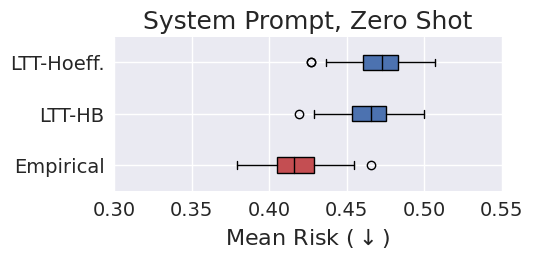

Experiment: mbpp_pass-10_mean_no_data_500_prompt_ind_2_full_results
Mean LttHB
Mean Hoeffding
Mean KS
Mean BJ


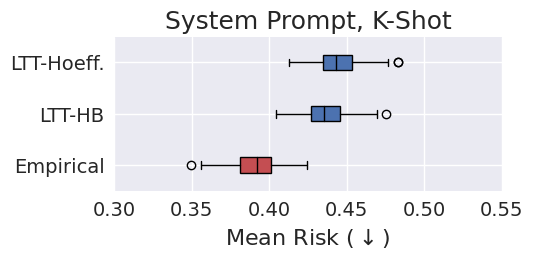

In [11]:
run_exp(
    dataset = "mbpp",
    loss_fn = "pass-10",
    prompt_ind = 0,
    measure = "Mean",
    single_prompt = True,
    no_data = 500,
    plt_title = "System Prompt, Zero Shot"
)

run_exp(
    dataset = "mbpp",
    loss_fn = "pass-10",
    prompt_ind = 2,
    measure = "Mean",
    single_prompt = True,
    no_data = 500,
    plt_title = "System Prompt, K-Shot"
)